In [2]:
from google.cloud import storage
import pandas as pd
import pyarrow.parquet as pq
import io
import ast
import numpy as np
import koreanize_matplotlib
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap

# 한글 깨짐 방지 (옵션)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

pd.set_option('display.max_columns', None)   # 컬럼 생략 없이 모두 출력
pd.set_option('display.width', None) 

plt.rcParams['font.family'] = 'NanumGothic'  # Windows # 나눔고딕 가능
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 부호 깨짐 방지

##### 상하위 25% 유저 테이블

In [3]:
cohort_25user = pd.read_csv("/home/project4/project4/master-top_bottom.csv")
cohort_25user.reset_index(drop = True)

,Unnamed: 0,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,ret_group,ret_group_over,ret_group_under,gender,group_id,school_id,grade,votes_within_3d_count,reported_user_count,vote_nunique_user_count,period_friend_count,sign_up_date,first_vote_date,first_point_use_date,first_point_use_amount,vote_sameday_signup,days_to_vote,days_to_point,days_to_point_after_vote,first_vote_hour,first_voteday_question_count,total_voted,total_read,opposite_sex_votes_received_count,opposite_sex_vote_received_ratio,candidate_count,chosen_count,ratio,address,student_count,school_type,firstquestion_id,first_question_text,first_question_category,retention_group
0,1,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,50 이상,50 이상,NaN,F,321.0,369.0,2.0,77,0.0,28.0,63.0,2023-04-19 15:10:56.560337,2023-05-02 22:42:05,2023-05-05 07:32:34,-300.0,0,13,15.0,2.0,22,9,343.0,19.0,46,0.134111,82.0,37.0,0.451220,충청남도 아산시,578,H,298,옷이 제일 많을 거 같은 사람은?,['일상' '스타일' '관찰'],top25
1,7,840512,131,7,2023-05-02,2023-05-16,14,2023-05-02,0.569444,50 이상,50 이상,NaN,M,930.0,369.0,1.0,69,0.0,42.0,16.0,2023-04-21 14:02:03.764186,2023-05-02 23:42:03,2023-05-03 05:10:18,-300.0,0,11,11.0,0.0,23,1,309.0,80.0,125,0.404531,90.0,28.0,0.311111,충청남도 아산시,578,H,219,마술이 눈속임이 아니라 마법이라고 생각할 것 같은 사람은?,['심리' '감성' '상상'],top25
2,8,840685,547,16,2023-05-02,2023-05-23,21,2023-05-02,0.569444,50 이상,50 이상,NaN,F,838.0,369.0,1.0,259,0.0,54.0,68.0,2023-04-21 15:23:53.149852,2023-05-02 22:22:58,2023-05-03 02:56:17,-300.0,0,11,11.0,0.0,22,12,257.0,182.0,103,0.400778,102.0,27.0,0.264706,충청남도 아산시,578,H,120,본인 방이 제일 깨끗할거 같은 사람은?,['일상' '스타일' '관찰'],top25
3,9,840902,245,13,2023-05-02,2023-05-17,15,2023-05-02,0.569444,50 이상,50 이상,NaN,F,1058.0,369.0,2.0,73,0.0,32.0,59.0,2023-04-22 00:10:16.615160,2023-05-02 22:33:49,2023-05-03 13:03:16,-300.0,0,10,11.0,0.0,22,6,201.0,138.0,58,0.288557,86.0,18.0,0.209302,충청남도 아산시,578,H,332,선물 고르는 센스가 가장 좋을 것 같은 사람은?,['일상' '스타일' '관찰'],top25
4,11,841576,227,11,2023-05-09,2023-05-21,12,2023-05-09,0.731602,50 이상,50 이상,NaN,F,1293.0,5491.0,2.0,53,0.0,63.0,72.0,2023-04-22 13:39:28.230920,2023-05-09 10:42:55,2023-05-12 08:40:30,-300.0,0,16,19.0,2.0,10,14,293.0,281.0,114,0.389078,89.0,23.0,0.258427,경기도 광주시,486,H,410,발냄새가 호두과자 냄새일 것 같은 사람은?,['일상' '상상' '관찰'],top25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492,4672,1497413,118,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,50 미만,NaN,50 미만,M,68957.0,4426.0,3.0,152,0.0,14.0,24.0,2023-05-24 15:25:34.222838,2023-05-24 15:28:33,2023-05-24 16:15:50,-200.0,1,0,0.0,0.0,15,36,200.0,120.0,68,0.340000,11.0,7.0,0.636364,경상남도 거제시,483,H,1046,졸업 후 동창회에서 청첩장 돌릴 것 같은 친구는?,['일상' '미래' '인간관계'],bottom25
2493,4673,1497699,15,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,50 미만,NaN,50 미만,M,4286.0,271.0,3.0,15,0.0,3.0,2.0,2023-05-24 15:46:42.625580,2023-05-24 15:47:22,NaN,NaN,1,0,NaN,NaN,15,7,12.0,0.0,3,0.250000,NaN,NaN,NaN,충청남도 천안시 서북구,491,H,336,제대로 놀 때 부르고 싶은 친구는?,['일상' '라이프스타일' '인간관계'],bottom25
2494,4674,1498168,30,2,2023-05-24,2023-05-25,1,2023-05-24,0.294118,50 미만,NaN,50 미만,M,70622.0,4426.0,3.0,54,0.0,2.0,8.0,2023-05-24 17:05:03.737980,2023-05-24 17:05:49,2023-05-25 09:03:53,-200.0,1,0,0.0,0.0,17,3,146.0,145.0,93,0.636986,8.0,1.0,0.125000,경상남도 거제시,483,H,911,답장 속도가 가장 빠른 사람은?,['일상' '대화' '인간관계'],bottom25
2495,4675,1498266,4,1,2023-05-24,2023-05-24,0,2023-05-24,0.294118,50 미만,NaN,50 미만,F,57558.0,1719.0,3.0,4,0.0,4.0,28.0,2023-05-24 18:11:40.915740,2023-05-24 18:15:38,NaN,NaN,1,0,NaN,NaN,18,4,34.0,0.0,18,0.529412,NaN,NaN,NaN,울산광역시 울주군,550,H,914,예술감각이 가장 뛰어난 친구는?,['성격' '관찰' '인간관계'],bottom25


In [4]:
# 필요없는 컬럼 drop
cohort_25user = cohort_25user.drop(['Unnamed: 0','ret_group', 'ret_group_over','ret_group_under'], axis = 1)
cohort_25user.head()

,user_id,total_votes,unique_days,first_vote,last_vote,active_days,cohort_day,retention_day8,gender,group_id,school_id,grade,votes_within_3d_count,reported_user_count,vote_nunique_user_count,period_friend_count,sign_up_date,first_vote_date,first_point_use_date,first_point_use_amount,vote_sameday_signup,days_to_vote,days_to_point,days_to_point_after_vote,first_vote_hour,first_voteday_question_count,total_voted,total_read,opposite_sex_votes_received_count,opposite_sex_vote_received_ratio,candidate_count,chosen_count,ratio,address,student_count,school_type,firstquestion_id,first_question_text,first_question_category,retention_group
0,838466,127,6,2023-05-02,2023-05-07,5,2023-05-02,0.569444,F,321.0,369.0,2.0,77,0.0,28.0,63.0,2023-04-19 15:10:56.560337,2023-05-02 22:42:05,2023-05-05 07:32:34,-300.0,0,13,15.0,2.0,22,9,343.0,19.0,46,0.134111,82.0,37.0,0.451220,충청남도 아산시,578,H,298,옷이 제일 많을 거 같은 사람은?,['일상' '스타일' '관찰'],top25
1,840512,131,7,2023-05-02,2023-05-16,14,2023-05-02,0.569444,M,930.0,369.0,1.0,69,0.0,42.0,16.0,2023-04-21 14:02:03.764186,2023-05-02 23:42:03,2023-05-03 05:10:18,-300.0,0,11,11.0,0.0,23,1,309.0,80.0,125,0.404531,90.0,28.0,0.311111,충청남도 아산시,578,H,219,마술이 눈속임이 아니라 마법이라고 생각할 것 같은 사람은?,['심리' '감성' '상상'],top25
2,840685,547,16,2023-05-02,2023-05-23,21,2023-05-02,0.569444,F,838.0,369.0,1.0,259,0.0,54.0,68.0,2023-04-21 15:23:53.149852,2023-05-02 22:22:58,2023-05-03 02:56:17,-300.0,0,11,11.0,0.0,22,12,257.0,182.0,103,0.400778,102.0,27.0,0.264706,충청남도 아산시,578,H,120,본인 방이 제일 깨끗할거 같은 사람은?,['일상' '스타일' '관찰'],top25
3,840902,245,13,2023-05-02,2023-05-17,15,2023-05-02,0.569444,F,1058.0,369.0,2.0,73,0.0,32.0,59.0,2023-04-22 00:10:16.615160,2023-05-02 22:33:49,2023-05-03 13:03:16,-300.0,0,10,11.0,0.0,22,6,201.0,138.0,58,0.288557,86.0,18.0,0.209302,충청남도 아산시,578,H,332,선물 고르는 센스가 가장 좋을 것 같은 사람은?,['일상' '스타일' '관찰'],top25
4,841576,227,11,2023-05-09,2023-05-21,12,2023-05-09,0.731602,F,1293.0,5491.0,2.0,53,0.0,63.0,72.0,2023-04-22 13:39:28.230920,2023-05-09 10:42:55,2023-05-12 08:40:30,-300.0,0,16,19.0,2.0,10,14,293.0,281.0,114,0.389078,89.0,23.0,0.258427,경기도 광주시,486,H,410,발냄새가 호두과자 냄새일 것 같은 사람은?,['일상' '상상' '관찰'],top25


In [5]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ['#f7f7f7', '#009688',  '#ffc107'])

## 1. 친구 및 관계 관련 차이 보기
    - 활동 기간 중 친구 수
    - 중복 없이 투표한 사용자 수
    - 이성 간 투표 경험
        - 이성의 반응 경험이 리텐션과 어떻게 연결될까?

In [6]:
# 성별은 두 집단별로 골고루 유사한 수치로 존재하는 것으로 보임
cohort_25user.groupby(['retention_group', 'gender']).size()

retention_group  gender
bottom25         F         639
                 M         605
top25            F         691
                 M         562
dtype: int64

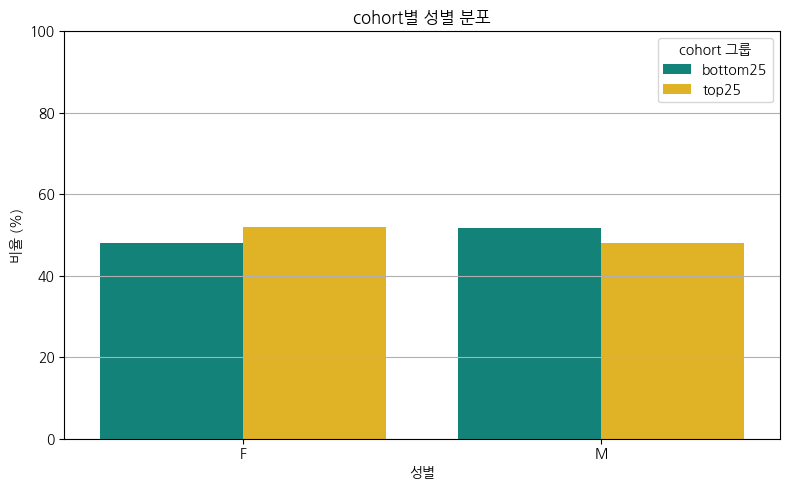

In [7]:
# 1. 성별-리텐션 그룹별 개수 집계
gender_group_counts = cohort_25user.groupby(['gender', 'retention_group']).size().unstack()

# 2. 성별 기준 비율 계산 후 백분율로 변환 
gender_group_percent = gender_group_counts.div(gender_group_counts.sum(axis=1), axis=0) * 100

# 1. melt로 긴 형식으로 변환
df_melted = gender_group_percent.reset_index().melt(id_vars='gender', var_name='retention_group', value_name='percentage')

# 2. 시각화
plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_melted,
    x='gender',
    y='percentage',
    hue='retention_group',
    palette=['#009688', '#ffc107']
)

plt.title('cohort별 성별 분포')
plt.xlabel('성별')
plt.ylabel('비율 (%)')
plt.ylim(0, 100)
plt.legend(title='cohort 그룹')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [8]:
# 성별간 교차 관련 투표 컬럼 추출
cross_gender_votes = cohort_25user.loc[:, ['user_id', 'gender', 'opposite_sex_votes_received_count', 'opposite_sex_vote_received_ratio', 'retention_group']]

In [9]:
# 선택받은 전체 투표 중 retention_group별 이성에게 받은 투표 비율
cross_gender_votes.groupby('retention_group')['opposite_sex_vote_received_ratio'].mean().reset_index()

,retention_group,opposite_sex_vote_received_ratio
0,bottom25,0.284096
1,top25,0.286679


In [10]:
# retention_group과 성별별 이성에게 받은 투표 수 count
cross_gender_votes.groupby(['retention_group', 'gender'])['opposite_sex_votes_received_count'].sum().reset_index()

,retention_group,gender,opposite_sex_votes_received_count
0,bottom25,F,30121
1,bottom25,M,29318
2,top25,F,48675
3,top25,M,46952


,retention_group,opposite_sex_vote_received_ratio
0,bottom25,0.284096
1,top25,0.286679


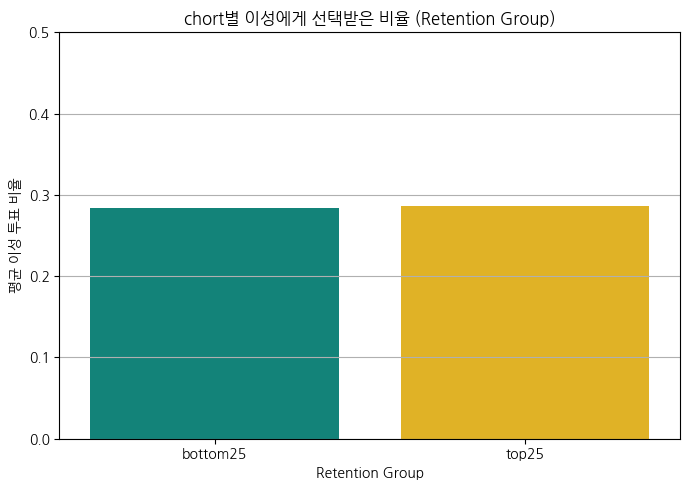

In [11]:
# 1. 평균값 계산
avg_ratio_by_group = cross_gender_votes.groupby('retention_group')['opposite_sex_vote_received_ratio'].mean().reset_index()
display(avg_ratio_by_group)
avg_ratio_by_group['opposite_vote_receive_ratio'] = avg_ratio_by_group['opposite_sex_vote_received_ratio'] * 100

# 2. 시각화
plt.figure(figsize=(7, 5))
sns.barplot(
    data=avg_ratio_by_group,
    x='retention_group',
    y='opposite_sex_vote_received_ratio',
    palette=['#009688', '#ffc107'],
    hue = 'retention_group'
)

plt.title('chort별 이성에게 선택받은 비율 (Retention Group)')
plt.xlabel('Retention Group')
plt.ylabel('평균 이성 투표 비율')
plt.ylim(0, 0.5)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### 이성에게 받은 투표 수 차이에 대한 통계 검정 플로우
- opposite_sex_votes_received_count 및 opposite_sex_vote_received_ratio를 통해 리텐션 그룹(top25 / bottom25)과 성별(M / F)에 따라 이성의 반응 경험 차이가 유의한지 검증

    1. 성별 제외 두 코흐트 집단 비교(비모수) : top25 vs bottom25
        - Mann-Whitney U Test

    2. 그룹별 평균 비교 : top25_M / top25_F / bottom25_M / bottom25_F

    3. 동일 코호트 내 성별 효과 비교 (비모수 검정)
        - 리텐션 그룹 내 성별 간 차이 유의성 확인
        - Mann-Whitney U Test(정규성 확인 하기 싫어서, 안전빵)
            - top25 남 vs 여
            - bottom25 남 vs 여
        
    4. 4그룹 평균 비교(One-way ANOVA)
        - 그룹 간 평균 차이 전체적으로 존재하는지 확인

    5. Tucky HSD(사후 검정)
        - ANOVA에서 유의할 경우 어떤 그룹 쌍 간의 차이가 유의한지 확인 위해 -> 추후 특정 코호트의 특정 성별에 대한 타겟팅

    6. 성별 제외 두 코흐트 집단 비교(비모수) : top25 vs bottom25
        - Mann-Whitney U Test

In [12]:
# 변수 의미 (코호트별임)
    # opposite_sex_votes_received_count 해당 성별 유저 1인당 이성에게 받은 투표 수 평균
    # opposite_sex_vote_received_ratio 해당 성별 유저 1인당 전체 투표 중 이성에게 받은 비율 평균

# 분석 대상 변수
target_vars = ['opposite_sex_votes_received_count', 'opposite_sex_vote_received_ratio']

# 필터: top25 & bottom25만 사용
df_filtered = cohort_25user[cohort_25user['retention_group'].isin(['top25', 'bottom25'])]

# 그룹 평균 비교표 생성
grouped = df_filtered.groupby(['retention_group', 'gender'])[target_vars].mean().reset_index()
print("그룹별 평균 비교:")
display(grouped)

그룹별 평균 비교:


,retention_group,gender,opposite_sex_votes_received_count,opposite_sex_vote_received_ratio
0,bottom25,F,47.137715,0.265121
1,bottom25,M,48.459504,0.304138
2,top25,F,70.441389,0.258902
3,top25,M,83.544484,0.320833


In [13]:
from scipy.stats import mannwhitneyu, f_oneway

# 통계 검정  (Top25 남 vs 여)
top_m = df_filtered[(df_filtered['retention_group'] == 'top25') & (df_filtered['gender'] == 'M')]
top_f = df_filtered[(df_filtered['retention_group'] == 'top25') & (df_filtered['gender'] == 'F')]

print("\n top25 남 vs 여 통계검정 결과:")
for var in target_vars:
    stat, p = mannwhitneyu(top_m[var], top_f[var], alternative='two-sided')
    print(f"{var} - Top25 남 vs 여: p-value = {round(p, 4)}")

# 3. bottom25 남 vs 여 Mann-Whitney U Test
bottom_m = df_filtered[(df_filtered['retention_group'] == 'bottom25') & (df_filtered['gender'] == 'M')]
bottom_f = df_filtered[(df_filtered['retention_group'] == 'bottom25') & (df_filtered['gender'] == 'F')]

print("\n Bottom25 남 vs 여 통계검정 결과:")
for var in target_vars:
    stat, p = mannwhitneyu(bottom_m[var], bottom_f[var], alternative='two-sided')
    print(f"{var} - Bottom25 남 vs 여:p-value: {round(p, 4)}")

# 4. 전체 4그룹 ANOVA 그룹
df_filtered['group'] = df_filtered['retention_group'] + "_" + df_filtered['gender']

# 5. ANOVA (One-way)
print("\n 전체 4그룹 One-way ANOVA 결과:")
for var in target_vars:
    groups = [df_filtered[df_filtered['group'] == g][var] for g in df_filtered['group'].unique()]
    stat, p = f_oneway(*groups)
    print(f"{var} - p-value: {round(p, 4)}")


 top25 남 vs 여 통계검정 결과:
opposite_sex_votes_received_count - Top25 남 vs 여: p-value = 0.0004
opposite_sex_vote_received_ratio - Top25 남 vs 여: p-value = 0.0

 Bottom25 남 vs 여 통계검정 결과:
opposite_sex_votes_received_count - Bottom25 남 vs 여:p-value: 0.0036
opposite_sex_vote_received_ratio - Bottom25 남 vs 여:p-value: 0.0001

 전체 4그룹 One-way ANOVA 결과:
opposite_sex_votes_received_count - p-value: 0.0
opposite_sex_vote_received_ratio - p-value: 0.0



================= opposite_sex_votes_received_count =================

 Tukey HSD 사후검정 결과:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
bottom25_F bottom25_M   1.3218 0.9813 -7.6196 10.2631  False
bottom25_F    top25_F  23.3037    0.0 14.6528 31.9545   True
bottom25_F    top25_M  36.4068    0.0 27.2914 45.5221   True
bottom25_M    top25_F  21.9819    0.0 13.2057 30.7581   True
bottom25_M    top25_M   35.085    0.0 25.8505 44.3194   True
   top25_F    top25_M  13.1031  0.001  4.1497 22.0565   True
------------------------------------------------------------

 2-way ANOVA 결과 (Retention × Gender):
                                    sum_sq      df           F        PR(>F)
C(retention_group)            5.173976e+05     1.0  137.627823  5.641322e-31
C(gender)                     3.221710e+04     1.0    8.569752  3.448886e-03
C(retention_group):C(gender)

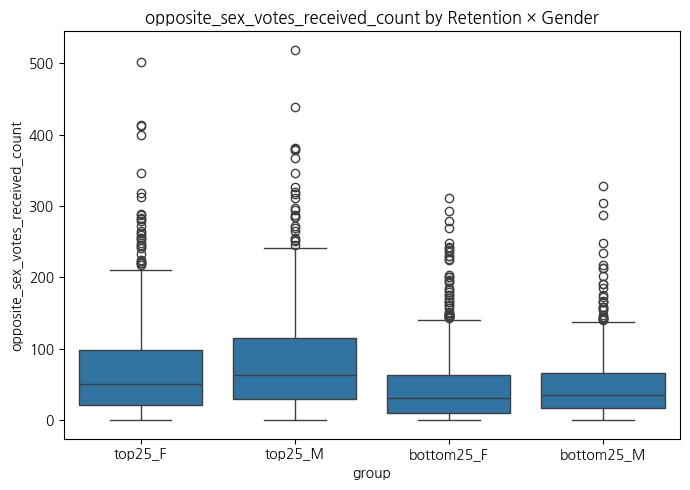


================= opposite_sex_vote_received_ratio =================

 Tukey HSD 사후검정 결과:
    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower   upper  reject
------------------------------------------------------------
bottom25_F bottom25_M    0.039 0.0004  0.0139  0.0641   True
bottom25_F    top25_F  -0.0062 0.9127 -0.0305  0.0181  False
bottom25_F    top25_M   0.0557    0.0  0.0301  0.0813   True
bottom25_M    top25_F  -0.0452    0.0 -0.0699 -0.0206   True
bottom25_M    top25_M   0.0167 0.3481 -0.0092  0.0426  False
   top25_F    top25_M   0.0619    0.0  0.0368  0.0871   True
------------------------------------------------------------

 2-way ANOVA 결과 (Retention × Gender):
                                 sum_sq      df          F        PR(>F)
C(retention_group)             0.012571     1.0   0.423934  5.150404e-01
C(gender)                      1.580323     1.0  53.295416  3.840328e-13
C(retention_group):C(gender)   0.081476  

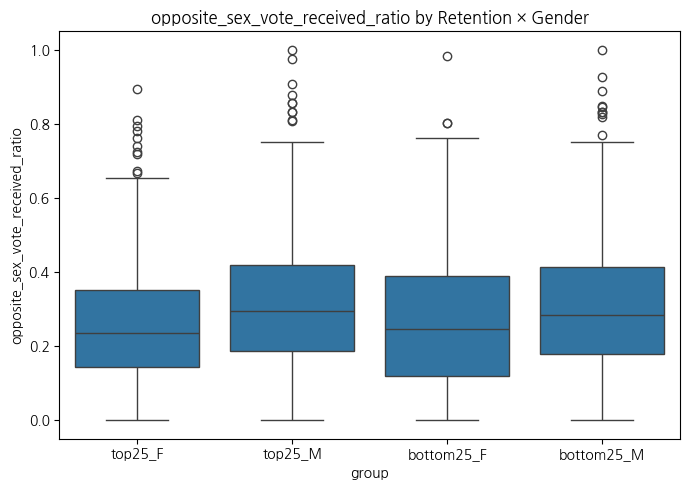

In [14]:
# 사후검정 & ANOVA용 모듈
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_filtered['group'] = df_filtered['retention_group'] + "_" + df_filtered['gender']

# 분석 변수
target_vars = ['opposite_sex_votes_received_count', 'opposite_sex_vote_received_ratio']

# 반복
for var in target_vars:
    print(f"\n================= {var} =================")

    # ▶ 1. Tukey HSD (사후검정)
    tukey = pairwise_tukeyhsd(endog=df_filtered[var],
                              groups=df_filtered['group'],
                              alpha=0.05)
    print("\n Tukey HSD 사후검정 결과:")
    print(tukey.summary())

    # ▶ 2. 2-way ANOVA with interaction
    model = ols(f'{var} ~ C(retention_group) * C(gender)', data=df_filtered).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print("\n 2-way ANOVA 결과 (Retention × Gender):")
    print(anova_table)

    # ▶ 3. 시각화
    plt.figure(figsize=(7, 5))
    sns.boxplot(data=df_filtered, x='group', y=var)
    plt.title(f'{var} by Retention × Gender')
    plt.tight_layout()
    plt.show()


In [15]:
# 필터링된 두 그룹
top = df_filtered[df_filtered['retention_group'] == 'top25']
bottom = df_filtered[df_filtered['retention_group'] == 'bottom25']

# 검정 대상 변수
target_vars = ['opposite_sex_votes_received_count', 'opposite_sex_vote_received_ratio']

print("\n Top25 vs Bottom25 (no 셩별):")
for var in target_vars:
    stat, p = mannwhitneyu(top[var], bottom[var], alternative='two-sided')
    print(f"{var} - p-value: {round(p, 4)}")



 Top25 vs Bottom25 (no 셩별):
opposite_sex_votes_received_count - p-value: 0.0
opposite_sex_vote_received_ratio - p-value: 0.651


## 2. 초기 경험이 리텐션에 영향을 미쳤는가
    - 첫 노출 질문

## 3. 투표 참여 유형
    - 후보로 등장한 빈도와 선택 받은 횟수

In [16]:
# retention_group 기준 그룹별 평균 및 표준편차
group_stats = cohort_25user.groupby('retention_group')[['candidate_count', 'chosen_count']].agg(['mean', 'std', 'count'])
print(group_stats)

                candidate_count                  chosen_count                 
                           mean        std count         mean        std count
retention_group                                                               
bottom25              36.754902  31.835900  1224    12.348039  12.041212  1224
top25                 46.231205  36.602473  1237    15.476960  14.173297  1237


### 횟수로 검정


 [기초 통계] 후보 등장 횟수 (candidate_count)
                  count       mean        std  min   25%   50%   75%    max
retention_group                                                            
bottom25         1224.0  36.754902  31.835900  1.0  14.0  28.0  50.0  272.0
top25            1237.0  46.231205  36.602473  1.0  19.0  38.0  62.0  258.0

 [기초 통계] 실제 선택 횟수 (chosen_count)
                  count       mean        std  min  25%   50%   75%    max
retention_group                                                           
bottom25         1224.0  12.348039  12.041212  0.0  4.0   9.0  17.0   84.0
top25            1237.0  15.476960  14.173297  0.0  5.0  12.0  21.0  108.0

[정규성 검정] Shapiro-Wilk Test (후보 수)
top25 그룹: ShapiroResult(statistic=0.8893105336381137, pvalue=7.120268691298349e-29)
bottom25 그룹: ShapiroResult(statistic=0.8489752382533795, pvalue=1.2757201732567817e-32)

 [등분산성 검정] Levene’s Test (후보 수)
LeveneResult(statistic=19.14451794252532, pvalue=1.2624132939757245e-05)

 [그룹 간 차이 검

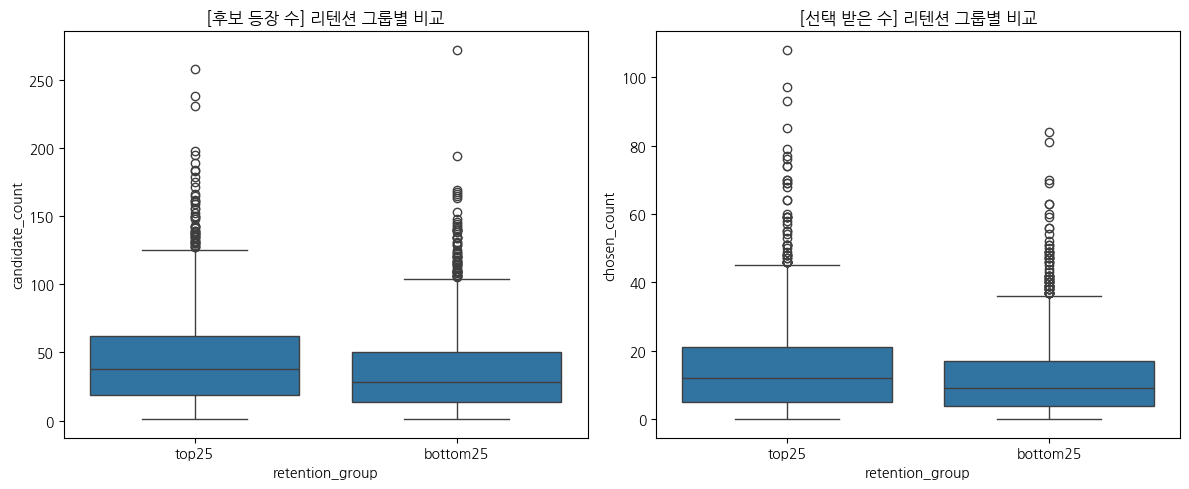

In [19]:
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

# 1. top25 / bottom25 그룹 분리 및 결측값 제거
top25 = cohort_25user[cohort_25user['retention_group'] == 'top25'].copy()
bottom25 = cohort_25user[cohort_25user['retention_group'] == 'bottom25'].copy()

# 후보 수와 선택 수의 NaN 제거
top25_candidate = top25['candidate_count'].dropna()
bottom25_candidate = bottom25['candidate_count'].dropna()
top25_chosen = top25['chosen_count'].dropna()
bottom25_chosen = bottom25['chosen_count'].dropna()

# 2. 그룹별 기초 통계 출력
print("\n [기초 통계] 후보 등장 횟수 (candidate_count)")
print(cohort_25user.groupby('retention_group')['candidate_count'].describe())

print("\n [기초 통계] 실제 선택 횟수 (chosen_count)")
print(cohort_25user.groupby('retention_group')['chosen_count'].describe())

# 3. 정규성 검정 (Shapiro-Wilk)
print("\n[정규성 검정] Shapiro-Wilk Test (후보 수)")
print("top25 그룹:", shapiro(top25_candidate))
print("bottom25 그룹:", shapiro(bottom25_candidate))

# 4. 등분산성 검정 (Levene)
print("\n [등분산성 검정] Levene’s Test (후보 수)")
print(levene(top25_candidate, bottom25_candidate))

# 5. Mann-Whitney U 검정 (비모수 검정)
print("\n [그룹 간 차이 검정] Mann-Whitney U Test 결과")
u1, p1 = mannwhitneyu(top25_candidate, bottom25_candidate, alternative='two-sided')
u2, p2 = mannwhitneyu(top25_chosen, bottom25_chosen, alternative='two-sided')
print(f"후보 등장 수(candidate_count): U = {u1}, p = {p1:.5f}")
print(f"실제 선택 수(chosen_count):     U = {u2}, p = {p2:.5f}")

# 6. 시각화 (박스플롯)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=cohort_25user, x='retention_group', y='candidate_count')
plt.title('[후보 등장 수] 리텐션 그룹별 비교')

plt.subplot(1, 2, 2)
sns.boxplot(data=cohort_25user, x='retention_group', y='chosen_count')
plt.title('[선택 받은 수] 리텐션 그룹별 비교')

plt.tight_layout()
plt.show()

 [기초 통계] 선택률 (ratio = chosen / candidate)
                  count      mean       std  min       25%       50%  \
retention_group                                                        
bottom25         1224.0  0.322486  0.168286  0.0  0.211285  0.333333   
top25            1237.0  0.325464  0.155786  0.0  0.227273  0.326087   

                      75%  max  
retention_group                 
bottom25         0.424432  1.0  
top25            0.413043  1.0  

 [정규성 검정] Shapiro-Wilk Test
top25: ShapiroResult(statistic=0.9625431206248026, pvalue=2.5942089388232084e-17)
bottom25: ShapiroResult(statistic=0.9737914109634938, pvalue=4.220867666555545e-14)

 [등분산성 검정] Levene’s Test
LeveneResult(statistic=10.20122440517235, pvalue=0.0014212212352449811)

 [그룹 간 차이 검정] Mann-Whitney U Test
선택률(ratio): U = 762126.5, p = 0.77306


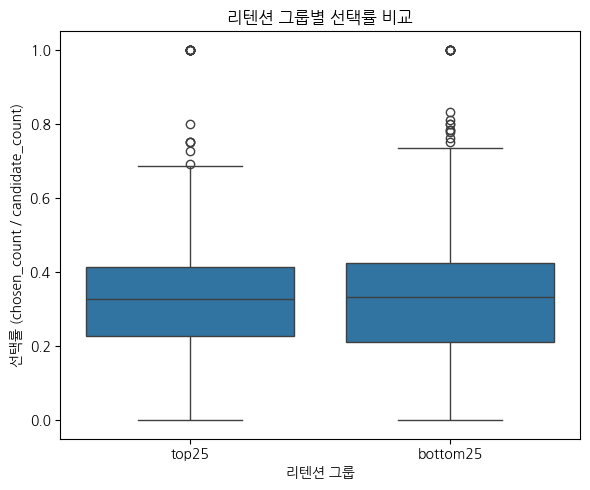

In [20]:
from scipy.stats import shapiro, levene, mannwhitneyu

# 1. ratio 컬럼 생성 (주의: 0으로 나누는 경우 제거)
cohort_25user = cohort_25user.copy()
cohort_25user['ratio'] = cohort_25user['chosen_count'] / cohort_25user['candidate_count']

# 무한대 또는 NaN 제거
cohort_25user = cohort_25user.replace([float('inf'), -float('inf')], pd.NA)
cohort_25user = cohort_25user.dropna(subset=['ratio'])

# 2. top25 / bottom25 그룹 분리
top25_ratio = cohort_25user[cohort_25user['retention_group'] == 'top25']['ratio']
bottom25_ratio = cohort_25user[cohort_25user['retention_group'] == 'bottom25']['ratio']

# 3. 기초 통계 출력
print(" [기초 통계] 선택률 (ratio = chosen / candidate)")
print(cohort_25user.groupby('retention_group')['ratio'].describe())

# 4. 정규성 검정
print("\n [정규성 검정] Shapiro-Wilk Test")
print("top25:", shapiro(top25_ratio))
print("bottom25:", shapiro(bottom25_ratio))

# 5. 등분산성 검정
print("\n [등분산성 검정] Levene’s Test")
print(levene(top25_ratio, bottom25_ratio))

# 6. 비모수 검정: Mann-Whitney U Test
print("\n [그룹 간 차이 검정] Mann-Whitney U Test")
u_stat, p_val = mannwhitneyu(top25_ratio, bottom25_ratio, alternative='two-sided')
print(f"선택률(ratio): U = {u_stat}, p = {p_val:.5f}")

# 7. 시각화
plt.figure(figsize=(6, 5))
sns.boxplot(data=cohort_25user, x='retention_group', y='ratio')
plt.title('리텐션 그룹별 선택률 비교')
plt.ylabel('선택률 (chosen_count / candidate_count)')
plt.xlabel('리텐션 그룹')
plt.tight_layout()
plt.show()

[기초 통계] 후보 등장률 (candidate_count / total_votes)
                  count      mean       std       min       25%       50%  \
retention_group                                                             
bottom25         1224.0  0.467436  1.031244  0.002725  0.093171  0.200000   
top25            1237.0  0.479737  2.917239  0.004884  0.092511  0.187773   

                      75%   max  
retention_group                  
bottom25         0.435514  14.0  
top25            0.358156  91.0  

[정규성 검정] Shapiro-Wilk Test
top25: ShapiroResult(statistic=0.07786867645407125, pvalue=1.2521800197843603e-60)
bottom25: ShapiroResult(statistic=0.3708579196096553, pvalue=8.416619315865051e-54)

 [등분산성 검정] Levene’s Test
LeveneResult(statistic=0.028561501718631113, pvalue=0.8658093739315547)

 [그룹 간 차이 검정] Mann-Whitney U Test
후보 등장률: U = 724224.0, p = 0.06259


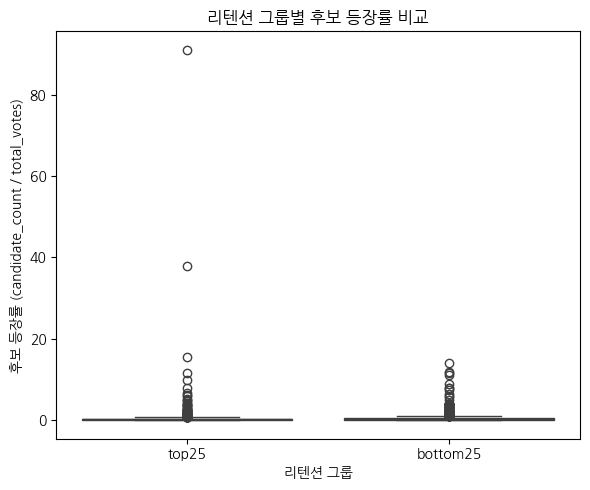

In [ ]:
# 1. 후보 등장률 계산: 후보 수 / 총 투표 수
cohort_25user = cohort_25user.copy()
cohort_25user['appearance_ratio'] = cohort_25user['candidate_count'] / cohort_25user['total_votes']

# 결측 제거
cohort_25user = cohort_25user.replace([float('inf'), -float('inf')], pd.NA)
cohort_25user = cohort_25user.dropna(subset=['appearance_ratio'])

# 2. 그룹 분리
top25_appearance = cohort_25user[cohort_25user['retention_group'] == 'top25']['appearance_ratio']
bottom25_appearance = cohort_25user[cohort_25user['retention_group'] == 'bottom25']['appearance_ratio']

# 3. 기초 통계 출력
print("[기초 통계] 후보 등장률 (candidate_count / total_votes)")
print(cohort_25user.groupby('retention_group')['appearance_ratio'].describe())

# 4. 정규성 검정
print("\n[정규성 검정] Shapiro-Wilk Test")
print("top25:", shapiro(top25_appearance))
print("bottom25:", shapiro(bottom25_appearance))

# 5. 등분산성 검정
print("\n [등분산성 검정] Levene’s Test")
print(levene(top25_appearance, bottom25_appearance))

# 6. 비모수 검정
print("\n [그룹 간 차이 검정] Mann-Whitney U Test")
u_stat, p_val = mannwhitneyu(top25_appearance, bottom25_appearance, alternative='two-sided')
print(f"후보 등장률: U = {u_stat}, p = {p_val:.5f}")

# 7. 시각화
plt.figure(figsize=(6, 5))
sns.boxplot(data=cohort_25user, x='retention_group', y='appearance_ratio')
plt.title('리텐션 그룹별 후보 등장률 비교')
plt.ylabel('후보 등장률 (candidate_count / total_votes)')
plt.xlabel('리텐션 그룹')
plt.tight_layout()
plt.show()